# Лабораторная работа №2

Исходные данные:
+ Датасет, согласно варианту (смотрим [тут](https://docs.google.com/spreadsheets/d/19lYYJEdA5IgjM2OHgqV0iGfREJCemXOBu1dsi2JteVo/edit?usp=sharing "Таблица"))

Что нужно сделать:
1. Осуществить предобработку данных (закодировать категориальные признаки, поработать с пропущенными значениями).  
2. Разделить данные на train и test выборку.
3. Обучить Scaler (sklearn.preprocessing.StandardScaler) на train, применить к train и test.  -- тут отшкалируем данные
2. Сделать класс MyDataDataset, который наследуется от Dataset, реализовать необходимый функционал. (датасеты будут train и test)
3. Инициализировать DataLoader с вашим MyDataDataset. (даталоадеры будет train и test)
4. Создать архитектуру нейросети.
5. Натренировать нейросеть на тренировочном множестве
6. Вывести метрики качества настроенной нейросети на трейне и тесте (accuracy, precision, recall, f1-score для классификации, MAE, RMSE, MAPE для регрессии).
7. Сделать выводы.
8. (Бонус) Визуализация функции ошибки и метрик при тренировке модели от эпохи к эпохе на трейне и тесте.

**Дедлайны**
- soft -- 23.11.2022
- hard -- начало зачетной недели

**Куда сдавать**
- telegram @l3lush
- почта m1603956@edu.misis.ru
- залить код в закрытый репозиторий и выдать права пользователю **l3lush**

# Пример, как импортить данные

In [26]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pandas.api.types import CategoricalDtype 


warnings.filterwarnings("ignore")


from sklearn.datasets import fetch_openml
name_of_dataset = "electricity"  # название вашего датасета из таблицы
data = fetch_openml(name=name_of_dataset)

In [27]:
# show the data
data.data

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912
...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579


In [28]:
data.target

0          UP
1          UP
2          UP
3          UP
4        DOWN
         ... 
45307    DOWN
45308    DOWN
45309    DOWN
45310      UP
45311    DOWN
Name: class, Length: 45312, dtype: category
Categories (2, object): ['UP', 'DOWN']

In [29]:
# show head of data
data.data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912


In [30]:
print(data.DESCR)

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the 

## 1 Предобработка данных

In [31]:
X = data.data

################################################################################################
# В результате экспериментов было решено не кодировать нейроны date и day, а исключить их  
# Подробнее в пункте 9 выводов                                                             


# Закордируем дни недели и даты, применив one_hot_encoded. 
# При этом число входных нейронов увеличится до 946
X =  pd.concat([X, pd.get_dummies(X['day'], prefix='day')],axis=1)
X.drop(['day'], axis=1, inplace=True, errors='ignore')

#X =  pd.concat([X, pd.get_dummies(X['date'], prefix='date')],axis=1)
#X.drop(['date'], axis=1, inplace=True, errors='ignore')

################################################################################################

# Исключим нейроны date и day, тогда число входных нейронов уменьшится на 2
X.drop(['date'], axis=1, inplace=True, errors='ignore')

# Закордируем period, применив one_hot_encode
# Число входных нейронов стало равно 53
#X =  pd.concat([X, pd.get_dummies(X['period'], prefix='period')],axis=1)
#X.drop(['period'], axis=1, inplace=True, errors='ignore')

print('X head: \n', X.head(), '\n-----------')

# Закордируем категориальные признаки так, что UP=1, DOWN=0
y = data.target.map({'UP':1, 'DOWN':0})
print('y head: \n', y.head(), '\n-----------')

# Приведем к типу Tensor
y=torch.tensor(y.to_numpy())

# Проверяем, что нет пропущенных значений ни в одной из колонок. Везде получаем 0, то есть данные не нуждаются
# в дополнительной обработке на пустые значения
print('The sum number of Nan values in all columns: \n', X.isnull().sum(axis = 0).sum, '\n-----------')

X head: 
      period  nswprice  nswdemand  vicprice  vicdemand  transfer  day_1  day_2  \
0  0.000000  0.056443   0.439155  0.003467   0.422915  0.414912      0      1   
1  0.021277  0.051699   0.415055  0.003467   0.422915  0.414912      0      1   
2  0.042553  0.051489   0.385004  0.003467   0.422915  0.414912      0      1   
3  0.063830  0.045485   0.314639  0.003467   0.422915  0.414912      0      1   
4  0.085106  0.042482   0.251116  0.003467   0.422915  0.414912      0      1   

   day_3  day_4  day_5  day_6  day_7  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0   
-----------
y head: 
 0    1
1    1
2    1
3    1
4    0
Name: class, dtype: category
Categories (2, int64): [1, 0] 
-----------
The sum number of Nan values in all columns: 
 <bound method NDFrame._add_numeric_operations.<locals>.sum of period       0
nswprice     0


In [33]:
# Проверим распределение y массива
pd.DataFrame(y).value_counts(normalize=True)

0    0.575455
1    0.424545
dtype: float64

## 2 Разделение на train и test

In [34]:
# Для сплита будем использовать функцию train_test_split из библиотеки sklearn.model_selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

X_train shape is (36249, 13)
y_train shape is torch.Size([36249])
X_test shape is (9063, 13)
y_test shape is torch.Size([9063])


## 3 Обучение Scaler

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sk = torch.tensor(scaler.transform(X_train))
X_test_sk = torch.tensor(scaler.transform(X_test))

print(X_test_sk)


tensor([[-0.6103, -0.7601,  0.6461,  ...,  2.4504, -0.4072, -0.4115],
        [ 1.4883,  0.7760,  0.5998,  ..., -0.4081, -0.4072,  2.4302],
        [-1.6958, -0.0818,  0.0658,  ...,  2.4504, -0.4072, -0.4115],
        ...,
        [-1.5511, -0.2778, -1.8709,  ..., -0.4081, -0.4072,  2.4302],
        [-0.8998, -0.7984, -1.4815,  ..., -0.4081, -0.4072, -0.4115],
        [ 0.6199,  0.7024, -0.4182,  ..., -0.4081,  2.4560, -0.4115]],
       dtype=torch.float64)


## 4 Создание собственного класса CustomDataDataset

In [36]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
        self.y_train = torch.tensor(y_train)
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

## 5 Инициализия DataLoader

In [37]:
train = CustomDataset(X_train_sk, y_train)
test = CustomDataset(X_test_sk, y_test)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

## 6 Создание архитектуры нейросети

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## 7 Тренировка нейросети

In [39]:
model = NeuralNetwork() 

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred_soft=torch.softmax(pred, dim=1).argmax(dim=1)
            test_loss += loss_fn(pred, y).item()
            accuracy = torch.sum(pred_soft == y).float()
    test_loss /= num_batches
    accuracy /= len(y)
    return [accuracy, test_loss]


In [40]:
# Инициализируем массивы для отрисовки графиков
epoch_list=list()
accuracy_list=list()
loss_list=list()

# Инициализируем параметры для обучения
learning_rate = 1e-2
batch_size = 256
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Обучаем
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    metrics_list=test_loop(test_dataloader, model, loss_fn)
    print(f"Epoch {t+1} finished --> Accuracy: {(100*metrics_list[0]):>0.1f}%, Avg loss: {metrics_list[1]:>8f}") 
    epoch_list.append(t)
    accuracy_list.append(metrics_list[0])
    loss_list.append(metrics_list[1])
    

Epoch 1 finished --> Accuracy: 84.6%, Avg loss: 0.498166
Epoch 2 finished --> Accuracy: 74.4%, Avg loss: 0.482375
Epoch 3 finished --> Accuracy: 71.8%, Avg loss: 0.478139
Epoch 4 finished --> Accuracy: 76.9%, Avg loss: 0.473986
Epoch 5 finished --> Accuracy: 87.2%, Avg loss: 0.472090
Epoch 6 finished --> Accuracy: 79.5%, Avg loss: 0.468832
Epoch 7 finished --> Accuracy: 79.5%, Avg loss: 0.467158
Epoch 8 finished --> Accuracy: 69.2%, Avg loss: 0.465274
Epoch 9 finished --> Accuracy: 76.9%, Avg loss: 0.465268
Epoch 10 finished --> Accuracy: 79.5%, Avg loss: 0.463028
Epoch 11 finished --> Accuracy: 82.1%, Avg loss: 0.461419
Epoch 12 finished --> Accuracy: 74.4%, Avg loss: 0.460626
Epoch 13 finished --> Accuracy: 79.5%, Avg loss: 0.458944
Epoch 14 finished --> Accuracy: 69.2%, Avg loss: 0.458555
Epoch 15 finished --> Accuracy: 76.9%, Avg loss: 0.458487
Epoch 16 finished --> Accuracy: 61.5%, Avg loss: 0.457632
Epoch 17 finished --> Accuracy: 76.9%, Avg loss: 0.456375
Epoch 18 finished --> A

## 8(10) Метрики

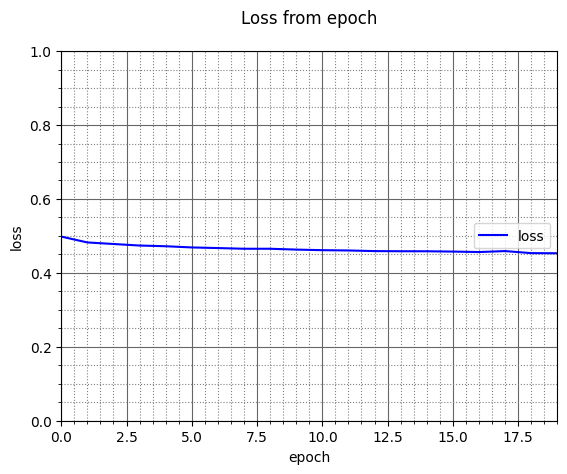

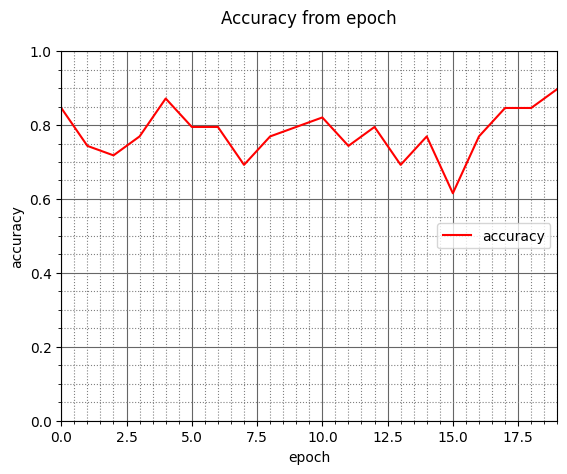

In [43]:
###################################
###  Построение графика потерь  ###
###################################
fig, axes = plt.subplots()


axes.plot(epoch_list, loss_list, color='blue', label='loss')
plt.title('Loss from epoch', pad = 20)
plt.ylabel('loss')
plt.xlabel('epoch')

axes.set_xlim(0, epoch_list[-1])
axes.set_ylim(0, 1)

plt.legend(loc=5)

# Добавление дополнительной ссетки
axes.grid(which='major', color = '#666666')
axes.minorticks_on()
axes.grid(which='minor', color = 'gray', linestyle = ':')


#####################################
###  Построение графика точности  ###
#####################################

fig, axes1 = plt.subplots()

axes1.plot(epoch_list, accuracy_list, color='red', label='accuracy')
plt.title('Accuracy from epoch', pad = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')

axes1.set_xlim(0, epoch_list[-1])
axes1.set_ylim(0, 1)

plt.legend(loc=5)

# Добавление дополнительной ссетки
axes1.grid(which='major', color = '#666666')
axes1.minorticks_on()
axes1.grid(which='minor', color = 'gray', linestyle = ':')

# Вывод отрисовки на экран
plt.show()

## 9 Выводы

* В случае, если переводить date и day в one_hot_encoded, входной слой будет состоять из 946 нейронов, что делает нейронную сеть довольно тяжелой. А сами параметры, вероятно, мало влияют на выходной результат, поэтому параметр date можно опустить. Параметр же day закодируем, тогда число входных нейронов будет равно 13
* Также закордируем категориальные презнаки для y. Так, Up=1 and Down=0
* В процессе подбора гиперапараметров для обучения нейрости был сделан вывод, что нейросеть обучается на первой эпохе и дальнейшей точности достичь этим датасетом не представляется возможным. Loss функции не падает ниже 0.4, а accuracy варируется в диапазоне 0.6-0.9. В процессе обучения были использованы различные комбинации learning_rate, batch_size, а также архитектуры сети разной степени сложности. Количество эпох, соответсвенно, также не влияет на конечный результат.